In [ ]:
import feed as f
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt  
# plt.style.use(plt.style.available[0])

from datetime import datetime
print(datetime.now())

In [ ]:
plt.style.available

### Updated and cleaned version of backtester

    1. Data
    2. Indicator
    3. Signal
    4. Trading rules
    5. Backtester
    6. Results

In [110]:
def prepare_df(df, period=10, inv=False) -> pd.DataFrame:  
    buy  = 1
    sell = -1
    if inv:
        buy  = -1
        sell = 1 
        
    # indicators
    df['lows']      = np.sign(df.L - df.L.shift(1))
    df['highs']     = np.sign(df.H - df.H.shift(1))    
    df['hilo']      = np.sign(df.lows + df.highs)
    df['mom']       = df.C.diff(period)
    df['mom_pos']   = np.sign(df.mom)
    df['mom_slope'] = np.sign(df.mom.diff(1))
    df.dropna(inplace=True)
    
    # Signal conditions
    c1 = df.hilo == 1
    c2 = df.mom_pos == 1
    c3 = df.mom_slope == 1
    c4 = df.hilo== -1
    c5 = df.mom_pos == -1
    c6 = df.mom_slope == -1
    df['signal'] = np.where(c1 & c2 & c3, buy, 0)
    df['signal'] = np.where(c4 & c5 & c6, sell, df.signal)
    
    #positioning
    df['position'] = np.where(df.signal.shift(1) ==  1,  1, 0)
    df['position'] = np.where(df.signal.shift(1) == -1, -1, df.position)
    return df

In [111]:
def run_backtest(frame, sl, tp, inst, showtrades=False):
    isOpen = False
    isStoppedout = False
    isTargetreached = False
    recentstop  = 0
    recenttarget  = 0    
    entry = 0
    pnl = 0
    position = 0
    trades = 0
    loss = 0
    win = 0    
    pSL = sl
    pTP = tp
    
    for x, r in frame.iterrows():
        # Long
        if (not isOpen) & (r.position == 1):
            entry = r.oa
            stop = entry - pSL/10000
            target = entry + pTP/10000
            if showtrades:
                print(x, 'Buy@{} sl@{:.5f} tp@{:.5f}'.format(entry, stop, target))
            recentstop = stop
            recenttarget = target
            position = 1
            isOpen=True
            isStoppedout = False
            trades +=1 

        if (position == 1) & showtrades:
            print('\t{} L:{:>5} H:{}'.format(x, r.L, r.H))

        if isOpen & (position == 1) & (r.lb< recentstop):
            tpnl = (recentstop-entry)*4000
            pnl += tpnl
            if showtrades:
                print(x, 'sl@ L:{} pnl: {:.5f}\n'.format(r.L, tpnl))
            loss += tpnl
            isOpen=False
            position = 0

        if isOpen & (position == 1) & (recenttarget < r.hb):
            tpnl = (recenttarget-entry)*4000
            pnl += tpnl
            win += tpnl
            if showtrades:
                print(x, 'tp@ {} H:{} L:{} C:{} pnl:{:.2f}\n'.format(r.O, r.H, r.L, r.C, tpnl))
            isOpen= False
            position = 0

        # Short
        if (not isOpen) & (r.position == -1):
            entry = r.ob
            stop = entry + pSL/10000
            target = entry - pTP/10000
            if showtrades:
                print(x, 'Sell@{} sl@{:.5f} tp@{:.5f}'.format(entry, stop, target))
            recentstop = stop
            recenttarget = target
            isOpen=True
            position = -1
            trades +=1

        if (position ==-1) & showtrades:
            print('\t{} H:{}'.format(x, r.L, r.H))

        if isOpen & (position == -1) & (recentstop < r.ha):
            tpnl = (entry - recentstop) * 4000
            pnl += tpnl
            loss += tpnl
            if showtrades:
                print(x, 'sl@ H:{} pnl: {:.5f}\n'.format(r.H, tpnl))
            isOpen=False
            position = 0

        if isOpen & (position == -1) &(recenttarget > r.la):
            tpnl = (entry - recenttarget)*4000
            pnl += tpnl
            win += tpnl
            if showtrades:
                print(x, 'tp@ {} L:{} pnl: {:.2f}\n'.format(r.O, r.H, r.L, r.C, tpnl))
            isOpen= False
            position = 0

        if (x == df.index[-1]) & showtrades:
            print(x, 'last H:{} L:{} C:{}'.format(r.H, r.L, r.C))   
    
    res = dict(inst=inst,
              sl=sl,
              tp=tp,
              pnl=pnl,
              win=win,
              loss=loss,
              trades=trades)
    return res

In [ ]:
def runSingleTest(df_copy):
    results=[]
    for SL in range(5, 25):
        for TP in range(5, 25):
            results.append(run_backtest(frame=df_copy, sl=SL, tp=TP, inst='EUR_USD', showtrades=False))
    return pd.DataFrame(results)            

In [ ]:
df = f.getcandles('EUR_USD',12*24*5, 'M5')
df.name = 'EUR_USD'

In [ ]:
PrepData(df, inv=True)
df_copy = df.copy(deep=True)           
df_res = runSingleTest(df_copy)
df_res.sample(5)

In [ ]:
df_res.describe().round(2)

In [ ]:
df_winners=df_res[df_res.pnl > 0].round(2)

In [ ]:
df_res[df_res.pnl > 0].round(2)

In [ ]:
plt.scatter(x=df_winners.sl, y=df_winners.tp);
plt.rcParams["figure.figsize"] = (5,2)

In [ ]:
plt.scatter(x=df_res2.sl, y=df_res2.tp);
plt.rcParams["figure.figsize"] = (5,2)

In [ ]:
inst = 'EUR_USD'
granu= 'M5'
count = 100

df = f.getcandles(inst,count, granu)
threshold = 0
slmin=1
slmax=30
tpmin=1
tpmax=30
PrepData(df, inv=True)
df.name=inst
for s in range(slmin, slmax):
    for t in range(tpmin, tpmax):
        r = doBacktest(df, sl=s, tp=t)
        if r[0]> threshold:
            print('normal', r[1])


PrepData(df, inv=False)
df.name=inst
for s in range(slmin, slmax):
    for t in range(tpmin, tpmax):
        r = doBacktest(df, sl=s, tp=t)
        if r[0]> threshold:
            print('inverse', r[1])        

## Kiegészítő funkciók

In [ ]:
def MultiPLot():
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex=True)

    d = df.iloc[50:300,:]

    d.C.plot(ax=axes[0])
    axes[0].set_ylabel("Close")

    d.position.plot(ax=axes[1])
    axes[1].set_ylabel("position")

    d.strategy.cumsum().apply(np.exp).plot(ax=axes[2])
    axes[2].set_ylabel("strategy") 

In [ ]:
dfs = []
def DownloadData():
    instruments = ['EUR_USD', 'EUR_AUD', 'EUR_NZD', 'EUR_CAD','EUR_JPY', 'EUR_CHF'
                   'GBP_USD', 'AUD_USD', 'NZD_USD', 'GBP_AUD', 'EUR_GBP','EUR_AUD',
                   'USD_CAD','EUR_CHF']
    
    for inst in instruments:
        print('Downloading:', inst)
        df = f.getcandles(inst,(12*24*5), 'M5')
        df.name = inst
        dfs.append(df)

DownloadData()    
print(len(dfs))
data = dfs.copy()
len(data)

In [130]:
results_inv =[]
for d in dfs:
    print(d.name, end='')
    prepare_df(d, inv=True)
    for SL in range(5, 25):
        print(f'.', end='')
        for TP in range(5, 25):
            results_inv.append(run_backtest(frame=d, sl=SL, tp=TP, inst=d.name, showtrades=False))
    print('')    

EUR_USD....................
GBP_USD....................
AUD_USD....................
NZD_USD....................
GBP_AUD....................
EUR_GBP....................
EUR_AUD....................
USD_CAD....................
EUR_CHF....................


In [135]:
df_inv= pd.DataFrame(results)

In [136]:
dfw_inv=df_inv[df_inv.pnl>0].sort_values(by='pnl', ascending=False).round(2)

In [116]:
df = pd.DataFrame(results)
dfw=df[df.pnl>0].sort_values(by='pnl', ascending=False).round(2)

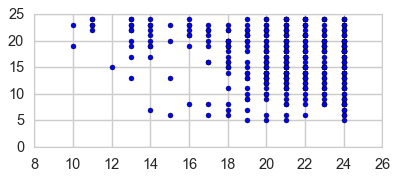

In [117]:
plt.scatter(x=dfw.sl, y=dfw.tp);
plt.rcParams["figure.figsize"] = (5,2)

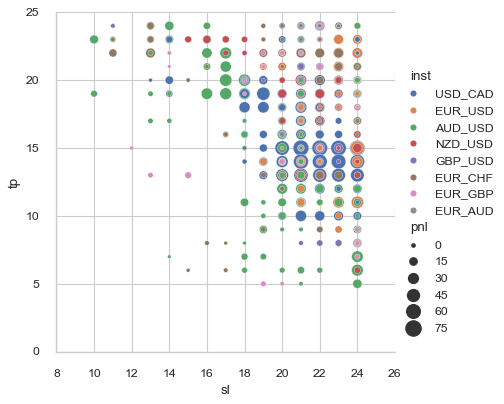

In [128]:
import seaborn as sns
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=dfw,
    x="sl", y="tp",
    hue="inst", size="pnl",
     sizes=(10, 200),
)
# g.set(xscale="log", yscale="log")
# g.ax.xaxis.grid(True, "minor", linewidth=.25)
# g.ax.yaxis.grid(True, "minor", linewidth=.25)
# g.despine(left=True, bottom=True)

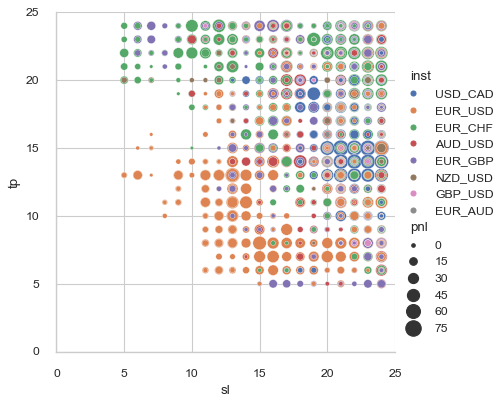

In [147]:
import seaborn as sns
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=dfw_inv,
    x="sl", y="tp",
    hue="inst", size="pnl",
     sizes=(10, 200),
)

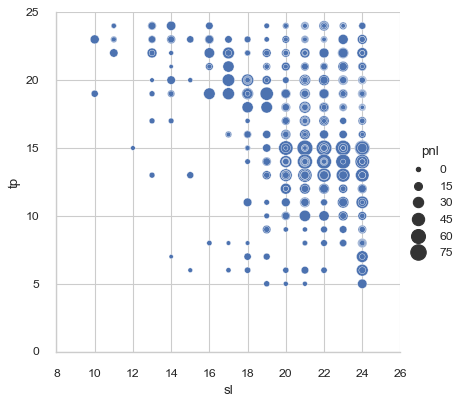

In [138]:
sns.relplot(x="sl", y="tp", size="pnl", sizes=(15, 200), data=dfw);

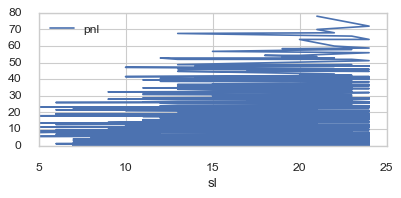

In [144]:
dfw_inv.plot(x= 'sl', y= 'pnl');